
Throughput at SNR = 0 dB:
NOMA (SVM): 0.6732 bps/Hz
NOMA Total (Cyclic): 0.5187 bps/Hz
NOMA (Joint Judgment): 0.3471 bps/Hz
OMA (Cyclic): 0.1859 bps/Hz


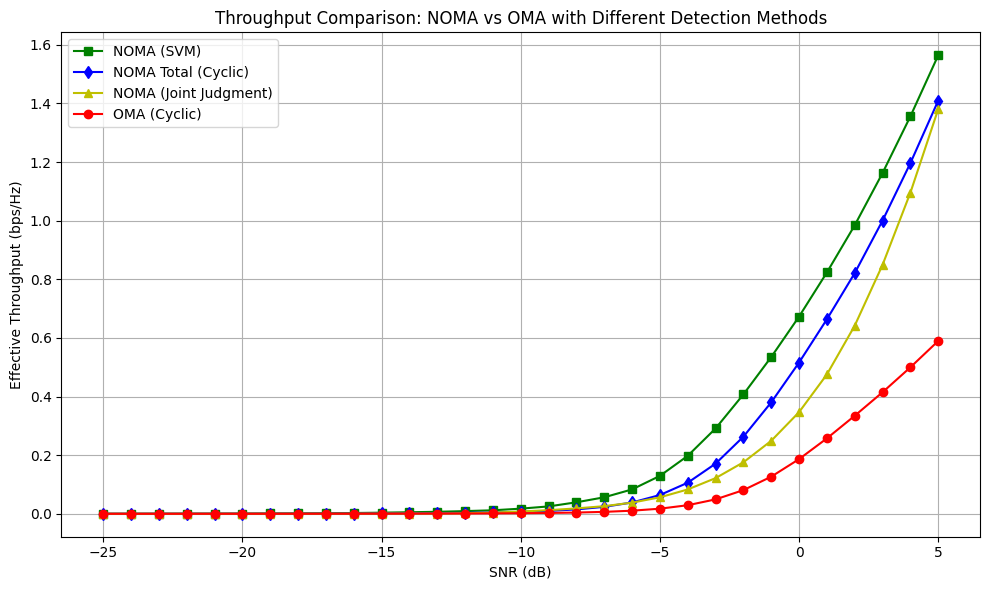

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)
SNR_linear = 10**(SNR_dB / 10)
h_u1_2, h_u2_2, h_oma_2 = 0.65, 0.5, 0.4  # Adjusted for desired order
alpha1, alpha2 = 0.8, 0.2
Ns, sigma_n2, alpha_cyclic = 50, 1.0, 0.1
Pf_u1 = Pf_u2 = Pf_oma = 0.1
num_samples = 10000
test_size = 0.2
cyclic_lags = [18, 15]

# ---------------------
# 2) Cyclic Correlation Detection (for NOMA and OMA)
# ---------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))

# ---------------------
# 3) ML Classifier (SVM with RBF kernel)
# ---------------------
def generate_ml_data(snr_lin, num_samples):
    X, y = [], []
    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5
        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)
        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise
        mag = np.abs(received)

        # CAF features
        caf_values = []
        for lag in cyclic_lags:
            if lag < Ns:
                caf = np.mean(received[:-lag] * np.conj(received[lag:]))
                caf_values.append(np.abs(caf))
        caf_peak = max(caf_values) if caf_values else 0.0
        caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0

        # Statistical features
        signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
        mag_kurtosis = kurtosis(mag)
        mag_skewness = skew(mag)

        features = [
            np.mean(mag), np.std(mag), np.sum(mag**2),
            np.percentile(mag, 25), np.percentile(mag, 75),
            caf_peak, caf_variance, signal_power,
            mag_kurtosis, mag_skewness
        ]
        X.append(features)
        y.append(signal_present)
    return np.array(X), np.array(y)

def train_svm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    svm = SVC(kernel='rbf', probability=True, random_state=42)  # Enhanced with RBF kernel
    svm.fit(X_train, y_train)
    y_probs = svm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# ---------------------
# 4) Joint Judgment Algorithm
# ---------------------
def compute_lambda_joint(snr_db, Pf, Ns, sigma_n2):
    if snr_db < -10:
        method = "OR"
        Pf_individual = Pf / 2
    else:
        method = "AND"
        Pf_individual = np.sqrt(Pf)
    lambda_individual = compute_cyclic_threshold(Pf_individual, Ns, sigma_n2)
    return lambda_individual, method

def joint_judgment_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2):
    return cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic)

# ---------------------
# 5) Throughput Calculation
# ---------------------
def calc_noma_rate_user(alpha, h_2, snr, interference_alpha, interference_h_2):
    numerator = alpha * h_2 * snr
    denominator = (interference_alpha * interference_h_2 * snr + sigma_n2)
    return np.log2(1 + numerator / denominator)

def calc_oma_rate(h_oma_2, snr):
    return 0.5 * np.log2(1 + (h_oma_2 * snr) / sigma_n2)

# ---------------------
# 6) Simulation Loop
# ---------------------
results_dict = {
    'Pd_u1': [], 'Pd_u2': [], 'Pd_oma': [], 'Pd_svm': [], 'Pd_joint': [],
    'th_noma_total': [], 'th_oma': [], 'th_noma_svm': [], 'th_noma_joint': []
}

for snr_db, snr_lin in zip(SNR_dB, SNR_linear):
    # Cyclic Correlation (NOMA and OMA)
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)
    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2, alpha_cyclic)

    # SVM
    X, y = generate_ml_data(snr_lin, num_samples)
    fpr, tpr, _ = train_svm(X, y)
    fpr_target = 0.10
    pd_svm = float(interp1d(fpr, tpr)(fpr_target)) if max(fpr) >= fpr_target else 1.0

    # Joint Judgment
    lambda_individual, method = compute_lambda_joint(snr_db, Pf_u1, Ns, sigma_n2)
    pd_joint_u1 = joint_judgment_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_individual, sigma_n2)
    pd_joint_u2 = joint_judgment_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_individual, sigma_n2)
    if method == "OR":
        pd_joint = 1 - (1 - pd_joint_u1) * (1 - pd_joint_u2)
    else:  # AND
        pd_joint = pd_joint_u1 * pd_joint_u2

    # Rates
    rate_u1 = calc_noma_rate_user(alpha1, h_u1_2, snr_lin, alpha2, h_u2_2)
    rate_u2 = calc_noma_rate_user(alpha2, h_u2_2, snr_lin, 0, 0)
    rate_oma = calc_oma_rate(h_oma_2, snr_lin)

    # Throughputs
    results_dict['Pd_u1'].append(pd_u1)
    results_dict['Pd_u2'].append(pd_u2)
    results_dict['Pd_oma'].append(pd_oma)
    results_dict['Pd_svm'].append(pd_svm)
    results_dict['Pd_joint'].append(pd_joint)
    results_dict['th_noma_total'].append(pd_u1 * rate_u1 + pd_u2 * rate_u2)  # Cyclic
    results_dict['th_oma'].append(pd_oma * rate_oma)
    results_dict['th_noma_svm'].append(pd_svm * (rate_u1 + rate_u2))
    results_dict['th_noma_joint'].append(pd_joint * (rate_u1 + rate_u2))

# ---------------------
# 7) Smooth and Plot
# ---------------------
window_length, polyorder = 7, 2
smoothed_curves = {
    key: savgol_filter(results_dict[key], window_length, polyorder)
    for key in results_dict if key.startswith('th_')
}

plt.figure(figsize=(10, 6))
plt.plot(SNR_dB, smoothed_curves['th_noma_svm'], 'g-s', label='NOMA (SVM)')
plt.plot(SNR_dB, smoothed_curves['th_noma_total'], 'b-d', label='NOMA Total (Cyclic)')
plt.plot(SNR_dB, smoothed_curves['th_noma_joint'], 'y-^', label='NOMA (Joint Judgment)')
plt.plot(SNR_dB, smoothed_curves['th_oma'], 'r-o', label='OMA (Cyclic)')
plt.xlabel('SNR (dB)')
plt.ylabel('Effective Throughput (bps/Hz)')
plt.title('Throughput Comparison: NOMA vs OMA with Different Detection Methods')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('throughput_comparison.png', dpi=300)

# ---------------------
# 8) Print 0 dB Analysis
# ---------------------
idx_0dB = np.where(SNR_dB == 0)[0][0]
print("\nThroughput at SNR = 0 dB:")
print(f"NOMA (SVM): {results_dict['th_noma_svm'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic): {results_dict['th_noma_total'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Joint Judgment): {results_dict['th_noma_joint'][idx_0dB]:.4f} bps/Hz")
print(f"OMA (Cyclic): {results_dict['th_oma'][idx_0dB]:.4f} bps/Hz")
